# Visualize predictions by all phages

In [109]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import linkage
from scipy.stats import mannwhitneyu, ttest_1samp, ttest_ind, ttest_rel
import seaborn as sns
import json
import pickle
import os

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, f1_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

np.random.seed(0)

plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = '15'

base_dir = os.getcwd()
print(base_dir)

%matplotlib inline

d:\These\30_dev\302_HR_predictions\+++\stratified_all_phages\adsorption_factors+core_genome_1e-4_quat


In [2]:
# interaction_matrix = pd.read_csv("D:\\These\\20_data\\212_interaction_matrices\\ADSORPTION_MATRIX_370+host.csv", sep=";").set_index("bacteria")
interaction_matrix = pd.read_csv("D:\\These\\20_data\\212_interaction_matrices\\CML_MATRIX_370+host_vs_96.csv", sep=";", na_values="NA").set_index("bacteria")

if "P" in interaction_matrix.values or "U" in interaction_matrix.values:
    interaction_matrix = interaction_matrix.replace({"N": 0, "P": 1, "F": np.nan, "U": 1})
    MODE = "QUALI"
else:
    MODE = "QUANTI"

print(f"Visualizing... {MODE} interaction matrix!")

phage_features = pd.read_csv("D:/These/20_data/201_genomic_data/097_phage/Phage_features_with_host.csv", sep=";").set_index("phage").loc[interaction_matrix.columns,]
bact_features = pd.read_csv("D:\\These\\20_data\\201_genomic_data\\370_and_host\\370+host_features_with_ABC_capsules.csv", sep=";").set_index("bacteria")
klesbiella_capsules = pd.read_csv("D:/These/30_dev/318_capsules/results/kaptive_results_high_hits_cured.txt", sep="\t").set_index("bacteria")

# Impose bacterial phylogenetic order and phage order in heatmap
interaction_matrix.loc["H1-005-0065-L-P"] = np.nan  # lost bacteria
interaction_matrix.loc["H27"] = np.nan  # lost bacteria
bacteria_order = np.loadtxt("D:\\These\\20_data\\201_genomic_data\\370_and_host\\host\\panacota\\Tree\\ordered_tree_leaves_370+host_origname.txt", delimiter=",", dtype=str)[::-1]  # load bacteria order

# add phage features group size
force_phage_order = {"Dhakavirus": 0, "Mosigvirus": 1, "Krischvirus": 2, "Tequatrovirus": 3, "Felixounavirus": 4, "Wifcevirus": 5, "Justusliebigvirus": 6, "Phapecoctavirus": 7, "Gamaleyavirus": 8, "Teseptimavirus": 9, "Przondovirus": 10, "Kayfunavirus": 11, "Vectrevirus": 12, "Veterinaerplatzvirus": 13, "Kagunavirus": 14, "Lambdavirus": 15, "Sashavirus": 16, "Wanchaivirus": 17, "Dhillonvirus": 18}
phage_features["order"] = phage_features["Genus"].apply(lambda x: force_phage_order[x])
phage_features = phage_features.reset_index().rename({"index": "phage"}, axis=1).sort_values(["order", "phage"]).set_index("phage")

interaction_matrix = interaction_matrix.loc[bacteria_order, phage_features.index]  # force phylogenetic ordering in the matrix

print(interaction_matrix.shape, phage_features.shape)

Visualizing... QUANTI interaction matrix!
(404, 96) (96, 11)


D:\Applications\Appdata\TEMP\ipykernel_13892\2179650655.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "P" in interaction_matrix.values or "U" in interaction_matrix.values:


In [100]:
perf_dir = f"{base_dir}\\results\\performances"

# get best models for each phage
best_models = []
for p in phage_features.index:
    perf = pd.read_csv(perf_dir + f"\\performance_{p}_Group10Fold_CV.csv", sep=";")

    # get best model on test set
    perf_by_model = perf.loc[perf["dataset"] == "test"].groupby("model")["avg_precision"].mean()
    best_model = perf_by_model.sort_values(ascending=False).index[0]

    best_models.append({"phage": p, "model": best_model})
best_models = pd.DataFrame(best_models)

# Get predictions by the best model for each phage
preds_dir = f"{base_dir}\\results\\predictions"
preds = []
for p in os.listdir(preds_dir):
    preds.append(pd.read_csv(preds_dir + "\\" + p, sep=";"))
all_predictions = pd.concat(preds, axis=0)

all_predictions = pd.merge(all_predictions, best_models, on=["phage", "model"])

# Get predictions on test set for each phage
predictions = all_predictions.loc[all_predictions["dataset"] == "test"]

# Measure performance
tn, fp, fn, tp = confusion_matrix(predictions["y"], predictions["y_pred"]).ravel()
precision, recall, f1 = precision_score(predictions["y"], predictions["y_pred"]), recall_score(predictions["y"], predictions["y_pred"]), f1_score(predictions["y"], predictions["y_pred"])
average_prec = average_precision_score(predictions["y"], predictions["y_pred_proba"])
roc_auc = roc_auc_score(predictions["y"], predictions["y_pred_proba"])

print("TP:", tp, ", FP:", fp, ", TN:", tn, ", FN:", fn)
print("Precision:", precision, ", Recall:", recall, ", F1:", f1)
print("Average Precision:", average_prec)
print("AUROC:", roc_auc)

TP: 4648 FP: 2980 TN: 27432 FN: 3318
Precision: 0.6093340325117986 Recall: 0.5834797891036907 F1: 0.5961267154033603
Average Precision: 0.6012381355535488
AUROC: 0.85689769900018


In [101]:
predictions = all_predictions.loc[all_predictions["dataset"] == "test"]

# Performance
tn, fp, fn, tp = confusion_matrix(predictions["y"], predictions["y_pred"]).ravel()
precision, recall, f1 = precision_score(predictions["y"], predictions["y_pred"]), recall_score(predictions["y"], predictions["y_pred"]), f1_score(predictions["y"], predictions["y_pred"])
average_prec = average_precision_score(predictions["y"], predictions["y_pred_proba"])
roc_auc = roc_auc_score(predictions["y"], predictions["y_pred_proba"])

print(tp, fp, tn, fn)
print(precision, recall, f1)
print(average_prec)
print(roc_auc)

print("\n")

4648 2980 27432 3318
0.6093340325117986 0.5834797891036907 0.5961267154033603
0.6012381355535488
0.85689769900018




In [107]:
from bokeh.models import BasicTicker, PrintfTickFormatter, HoverTool
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.io import export_svg

def get_score(y_pred, y_true):
    if y_pred == 0 and y_true == 0:
        return 0  # TN
    elif y_pred == 0 and y_true == 1:
        return -1  # FN
    elif y_pred == 1 and y_true == 1:
        return 1  # TP
    elif y_pred == 1 and y_true == 0:
        return 2  # FP
    else:
        raise ValueError(f"y_pred and y_true should be either 0 or 1! y_pred={y_pred} and y_true={y_true} passed.")

# reshape to 1D array with one phage-bacteria interaction per line
df = predictions.copy()
scores = []
for i, row in predictions.iterrows():
    scores.append(get_score(row["y_pred"], row["y"]))
df["score"] = scores

# sort bacteria and phages
df = df.set_index("bacteria")

# add bacterial and phage genomic features
df = pd.merge(left=df, right=bact_features[["Clermont_Phylo", "ST_Warwick", "LPS_type", "O-type", "H-type", "Klebs_capsule_type", "ABC_serotype"]], left_on="bacteria", right_index=True)
df = pd.merge(left=df, right=phage_features[["Morphotype", "Genus", "Phage_host"]], left_on="phage", right_index=True)
df = df.rename({"O-type": "O", "H-type": "H"}, axis=1).reset_index()

bacteria = np.loadtxt("D:\\These\\20_data\\201_genomic_data\\370_and_host\\host\\panacota\\Tree\\ordered_tree_leaves_370+host_origname.txt", delimiter=",", dtype=str)[::-1]  # load bacteria order
phages = list(phage_features.index)

# Choose colormap that suits the interaction matrix type
# colors = sns.color_palette(["#00A6EE", "#f8f9fa", "#FCC500", "#DC3220"]).as_hex()
colors = sns.color_palette(["#B1AFAF", "#ffffff", "#214D96", "#A33C3C"]).as_hex()

# Display image and genomic features in hover
hover = """
    <div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@bacteria vs. @phage</span>
        </div>
        <div>
            <span style="font-size: 14px; color: #119; font-weight: bold;">y_pred=@y_pred vs. y=@y</span>
        </div>
        <div>
            <span style="font-size: 14px; color: #119; font-weight: bold;">@model</span>
        </div>
        <div>
            <span style="font-size: 10px; color: #911;">Phylogroup: @Clermont_Phylo \n</span>
        </div>
        <div>
            <span style="font-size: 10px; color: #911;">ST: @ST_Warwick \n</span>
        </div>
        <div>
           <span style="font-size: 10px; color: #911;">LPS: @LPS_type \n</span>
        </div>
        <div>
           <span style="font-size: 10px; color: #911;">O-type: @O \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">H-type: @H \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">Klebs K-type: @Klebs_capsule_type \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">ABC K-type: @ABC_serotype \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Morphotype: @Morphotype \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Genus: @Genus \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Isolation host: @Phage_host \n</span>
        </div>
    </div>
"""

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title="",#f"Adsorption factors + Core genome @ 1e-4\nPrecision={round(precision, 2)}, Recall={round(recall, 2)}, AvPrecision={round(average_prec, 2)}",
           x_range=bacteria, y_range=phages[::-1],
           x_axis_location="above", width=1500, height=700, tools=TOOLS,
           tooltips=hover)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi / 3
p.axis.visible = False

r = p.rect(x="bacteria", y="phage", width=1, height=1, source=df,
           fill_color=linear_cmap("score", colors, low=-1, high=2),
           line_color="#dddddd", line_width=0.25)

# p.add_layout(r.construct_color_bar(
#     major_label_text_font_size="7px",
#     ticker=BasicTicker(desired_num_ticks=len(colors)),
#     # formatter=PrintfTickFormatter(format="%d%"),
#     label_standoff=6,
#     border_line_color=None,
#     padding=5
# ), 'right')

# show figure or export it in svg format
do_export_figure = False
if do_export_figure:
    p.output_backend = "svg"
    export_svg(p, filename="D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Prediction matrix/images/prediction_matrix.svg")
    # export_png(p, filename="D:\\These\\20_data\\213_data_nico\\cml_matrix_root=albertii.png")
else:
    show(p)

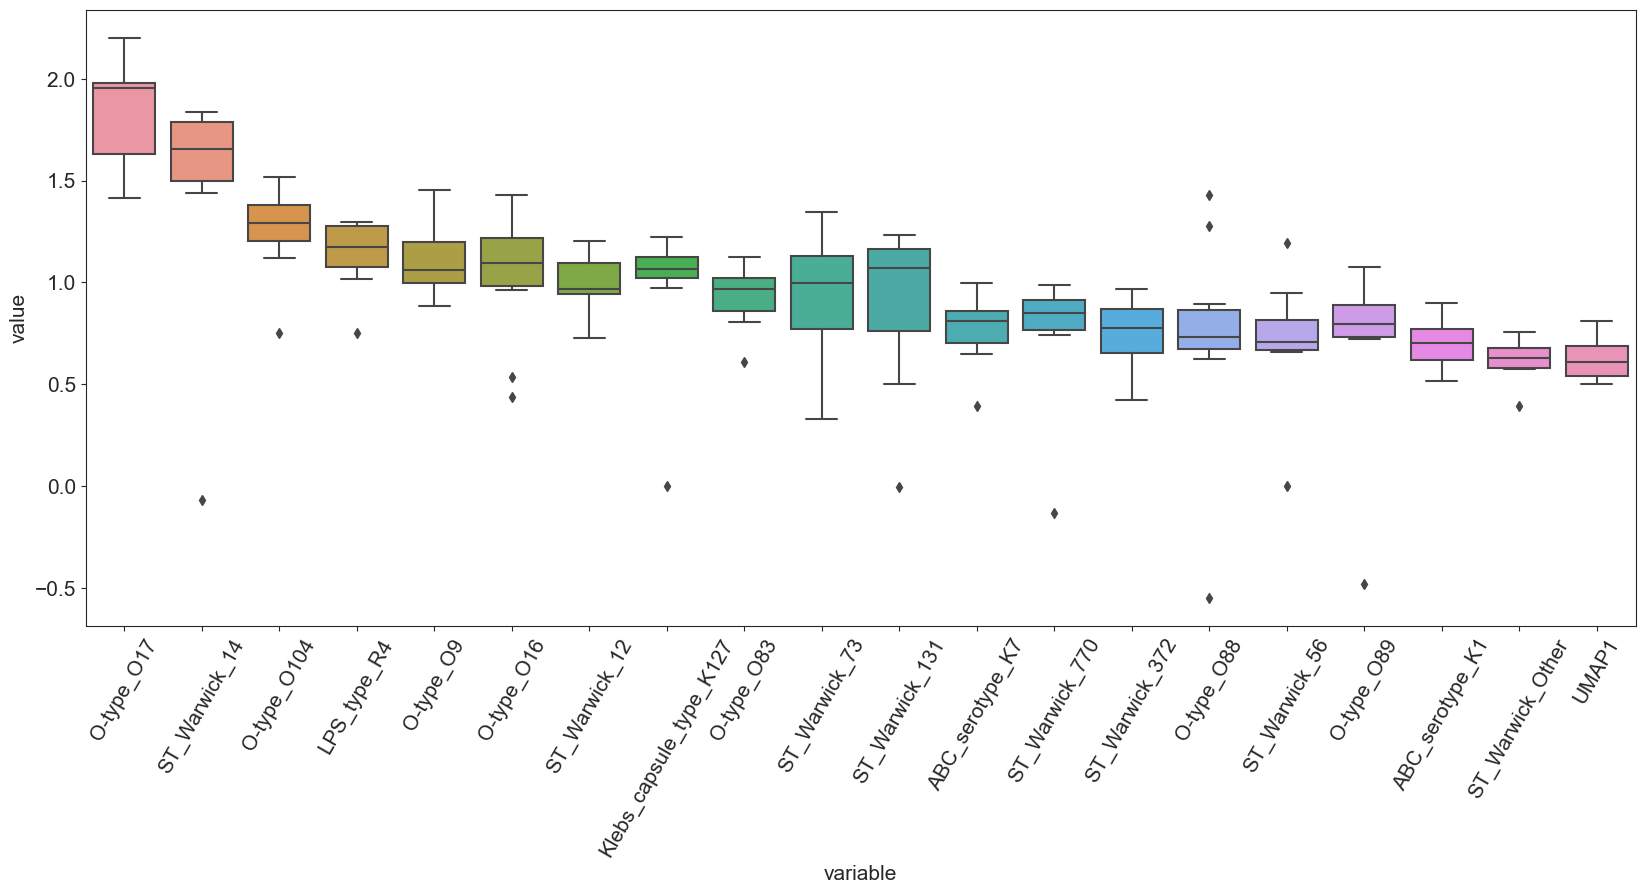

In [102]:
# Feature importance for each phage-specific model
fp = pd.read_csv(f"{base_dir}\\results\\feature_importances\\T7_Portugal_feature_importance.csv", sep=";")

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
bx = sns.boxplot(data=fp.sort_values("average_importance", ascending=False)[:200], x="variable", y="value", ax=ax)
t = ax.set_xticklabels(bx.get_xticklabels(), rotation=60)

### Performance per phage

In [115]:
perf = []
for p, pred in df.groupby("phage"):
    y_pred, y_pred_proba, y_true = pred["y_pred"], pred["y_pred_proba"], pred["y"]
    n_infections = pred["y"].sum()
    prec, rec, auc = precision_score(y_true, y_pred), recall_score(y_true, y_pred), roc_auc_score(y_true, y_pred_proba)
    perf.append({"phage": p, "n_infections": n_infections,  "precision": prec, "recall": rec, "auc": auc})
perf = pd.DataFrame(perf)

perf["model"] = "AF"

do_save = False
if do_save:
    perf.to_csv("per_phage_perf.csv", sep=",", index=False)

perf

,phage,n_infections,precision,recall,auc,model
0,409_P1,11.0,0.222222,0.181818,0.822165,AF
1,409_P3,12.0,0.363636,0.333333,0.967700,AF
2,409_P5,14.0,0.000000,0.000000,0.969759,AF
3,409_P6,17.0,0.800000,0.470588,0.978596,AF
4,409_P8,9.0,0.571429,0.444444,0.978917,AF
...,...,...,...,...,...,...
91,NRG_11A2,127.0,0.493333,0.582677,0.731036,AF
92,NRG_11B1,121.0,0.556391,0.611570,0.779830,AF
93,NRG_12A1B,48.0,0.461538,0.125000,0.671669,AF
94,T4LD,94.0,0.225490,0.244681,0.533405,AF


### Compare performance on train vs. test set

In [18]:
train_test_perf, train_test_diff = [], []
for g, grp in all_predictions.groupby(["phage", "fold"]):
    train_obs, test_obs = grp.loc[grp["dataset"] == "train"], grp.loc[grp["dataset"] == "test"]
    try:
        train_prec, train_rec, train_auc = precision_score(train_obs["y"], train_obs["y_pred"]), recall_score(train_obs["y"], train_obs["y_pred"]), roc_auc_score(train_obs["y"], train_obs["y_pred_proba"])
        test_prec, test_rec, test_auc = precision_score(test_obs["y"], test_obs["y_pred"]), recall_score(test_obs["y"], test_obs["y_pred"]), roc_auc_score(test_obs["y"], test_obs["y_pred_proba"])
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "train", "precision": train_prec, "recall": train_rec, "auc": train_auc})
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "test", "precision": test_prec, "recall": test_rec, "auc": test_auc})
        train_test_diff.append({"phage": g[0], "fold": g[1], "precision": train_prec - test_prec, "recall": train_rec - test_rec, "auc": train_auc - test_auc})
    except:
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "train", "precision": np.nan, "recall": np.nan, "auc": np.nan})
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "test", "precision": np.nan, "recall": np.nan, "auc": np.nan})
        train_test_diff.append({"phage": g[0], "fold": g[1], "precision": np.nan, "recall": np.nan, "auc": np.nan})
train_test_perf = pd.DataFrame(train_test_perf)
train_test_diff = pd.DataFrame(train_test_diff)

train_test_diff["auc"] = train_test_diff["auc"] * 100  # percentage

train_test_diff

,phage,fold,precision,recall,auc
0,409_P1,0,0.727273,0.800000,1.819117
1,409_P1,1,0.642857,0.900000,76.493277
2,409_P1,2,NaN,NaN,NaN
3,409_P1,3,NaN,NaN,NaN
4,409_P1,4,0.571429,0.666667,2.054499
...,...,...,...,...,...
955,T7_Portugal,5,0.283660,0.407834,34.989806
956,T7_Portugal,6,0.293827,0.555556,37.829108
957,T7_Portugal,7,0.369919,0.531746,30.707790
958,T7_Portugal,8,0.351119,0.518433,33.032398


In [ ]:
# Statistical test for overfitting
train_test_perf = train_test_perf.sort_values(["phage", "fold", "dataset"])

all_pv = []
for p, grp in train_test_perf.groupby("phage"):
    train, test = grp.loc[grp["dataset"] == "train"].dropna().rename({"auc": "train_auc"}, axis=1), grp.loc[grp["dataset"] == "test"].dropna().rename({"auc": "test_auc"}, axis=1)
    all_perf = pd.merge(train, test, on="fold")
    t, pval = ttest_ind(all_perf["train_auc"], all_perf["test_auc"])

    correct_pval = True
    if correct_pval:
        all_pv.append({"phage": p, "t": t, "p": pval*96})
    else:
        all_pv.append({"phage": p, "t": t, "p": pval*96})
all_pv = pd.DataFrame(all_pv)

print("#phages with significant association:", all_pv.loc[all_pv["p"] < 0.01].shape[0])

all_pv

D:\Applications\Appdata\TEMP\ipykernel_13892\480140905.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, pval = ttest_ind(all_perf["train_auc"], all_perf["test_auc"])
D:\Applications\Appdata\TEMP\ipykernel_13892\480140905.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, pval = ttest_ind(all_perf["train_auc"], all_perf["test_auc"])
D:\Applications\Appdata\TEMP\ipykernel_13892\480140905.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, pval = ttest_ind(all_perf["train_auc"], all_perf["test_auc"])


,phage,t,p
0,409_P1,1.683420,11.338180
1,409_P3,1.485018,15.679529
2,409_P5,3.081635,0.912862
3,409_P6,1.773264,9.748122
4,409_P8,1.201797,26.373105
...,...,...,...
91,NRG_11A2,5.654557,0.002212
92,NRG_11B1,5.628755,0.002335
93,NRG_12A1B,9.003628,0.000004
94,T4LD,8.315536,0.000014


16.329110831908967


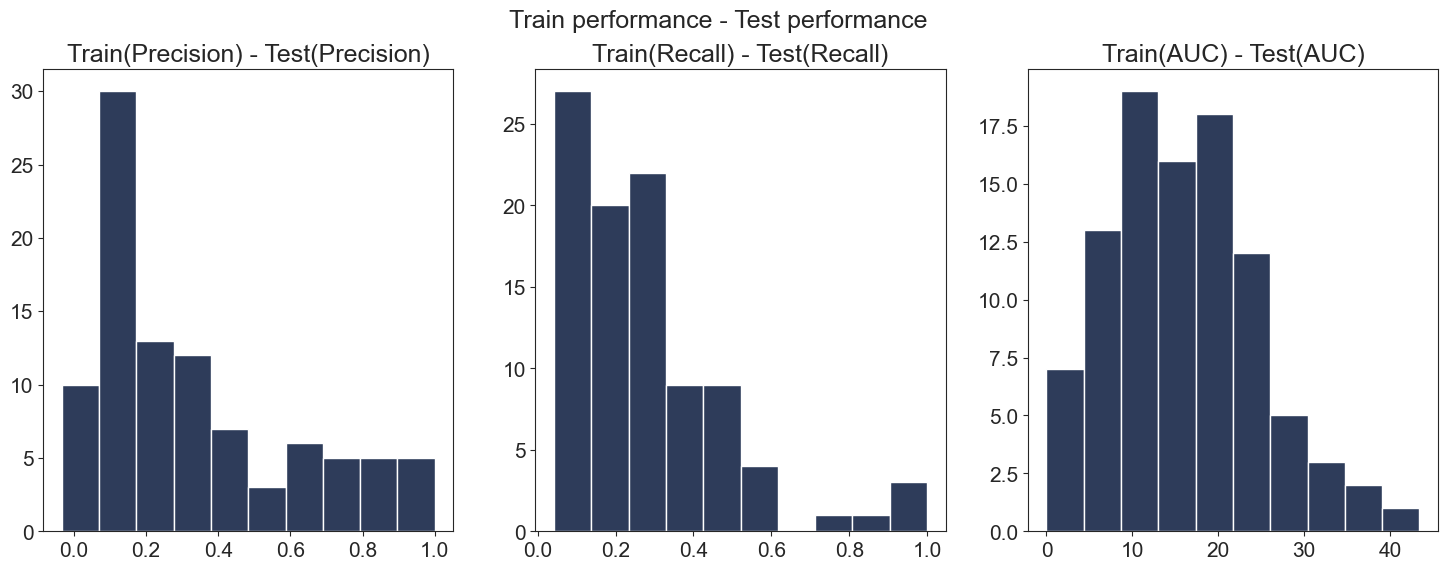

In [120]:
averaged_per_phage = train_test_diff.groupby("phage").mean()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(x=averaged_per_phage["precision"], color="#2E3C5A")
ax[0].set_title("Train(Precision) - Test(Precision)")
ax[1].hist(x=averaged_per_phage["recall"], color="#2E3C5A")
ax[1].set_title("Train(Recall) - Test(Recall)")
ax[2].hist(x=averaged_per_phage["auc"], color="#2E3C5A")
ax[2].set_title("Train(AUC) - Test(AUC)")

fig.suptitle("Train performance - Test performance")
print(train_test_diff["auc"].mean())

In [121]:
perf

,phage,n_infections,precision,recall,auc,model
0,409_P1,11.0,0.222222,0.181818,82.216495,AF
1,409_P3,12.0,0.363636,0.333333,96.770026,AF
2,409_P5,14.0,0.000000,0.000000,96.975881,AF
3,409_P6,17.0,0.800000,0.470588,97.859563,AF
4,409_P8,9.0,0.571429,0.444444,97.891738,AF
...,...,...,...,...,...,...
91,NRG_11A2,127.0,0.493333,0.582677,73.103551,AF
92,NRG_11B1,121.0,0.556391,0.611570,77.983000,AF
93,NRG_12A1B,48.0,0.461538,0.125000,67.166902,AF
94,T4LD,94.0,0.225490,0.244681,53.340495,AF


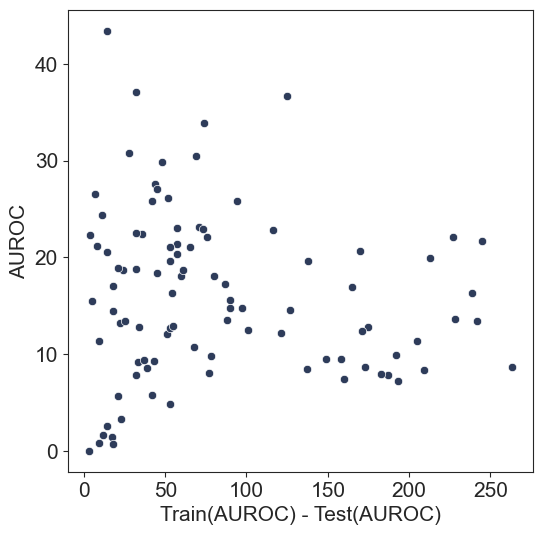

In [123]:
# Test AUC a.a.f.o (Train-Test AUC) 
n_infect = predictions.groupby("phage")["y"].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
to_plot = pd.merge(averaged_per_phage.rename({"auc": "train_test_auc"}, axis=1), perf, on="phage")
sns.scatterplot(data=to_plot, x="n_infections", y="train_test_auc", color="#2E3C5A")
ax.set_xlabel("Train(AUROC) - Test(AUROC)")
ax.set_ylabel("AUROC")

do_save = False
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 4 - Inference bacteria/data/overfitting/overfitting_vs_prevalence.svg")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=averaged_per_phage, x="n_infections", y="train_test_auc", ax=ax, color="#2D3C5A", s=50)
ax.set_xlabel("Lytic interactions")
ax.set_ylabel("AUROC (%)")

do_save = True
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/train_test_auc_vs_prevalence.svg")

### Performance on test set

Text(0.5, 1.0, 'AUC')

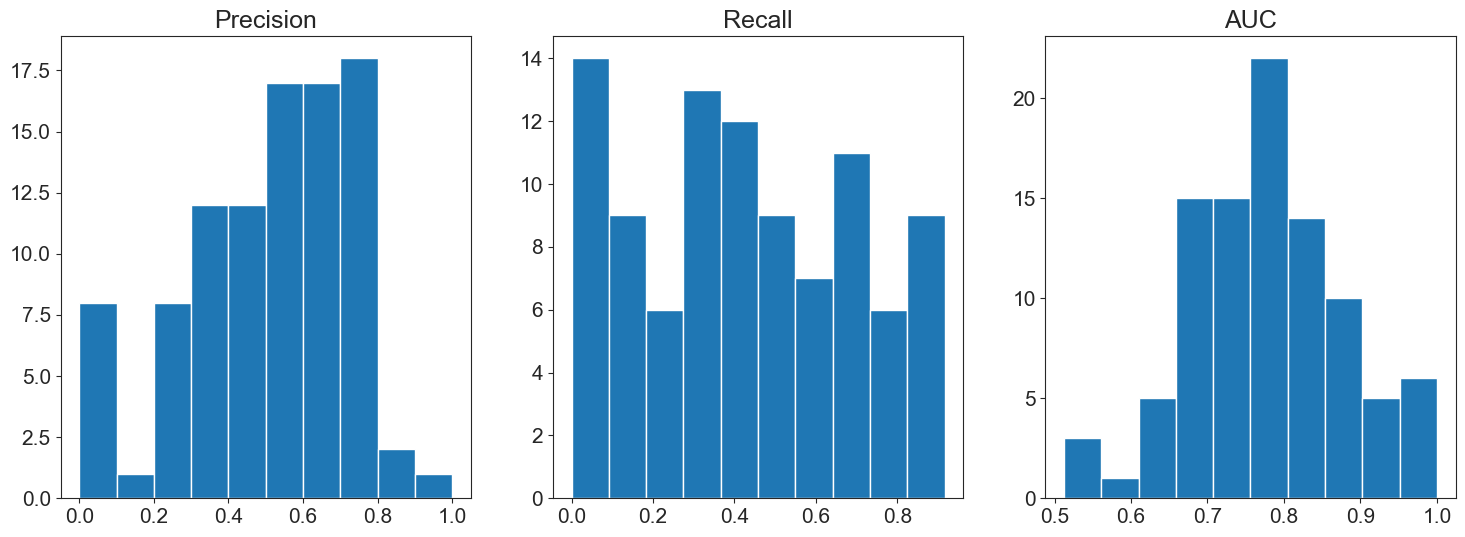

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(x=perf["precision"])
ax[0].set_title("Precision")
ax[1].hist(x=perf["recall"])
ax[1].set_title("Recall")
ax[2].hist(x=perf["auc"])
ax[2].set_title("AUC")

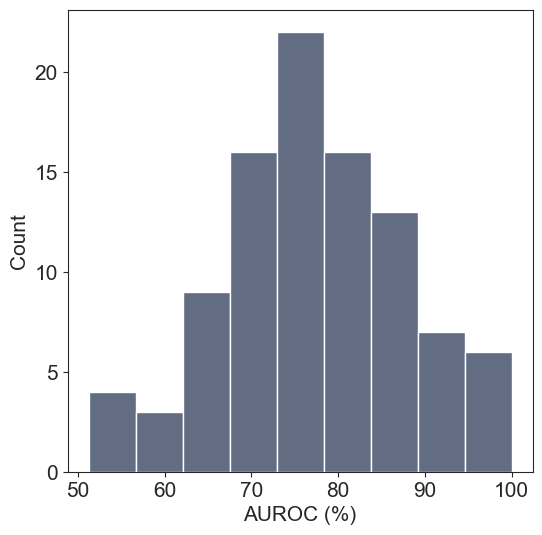

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
perf["auc"] = perf["auc"] * 100
sns.histplot(data=perf, x="auc", ax=ax, color="#2D3C5A")
ax.set_xlabel("AUROC (%)")
plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/auc_distrib.svg")

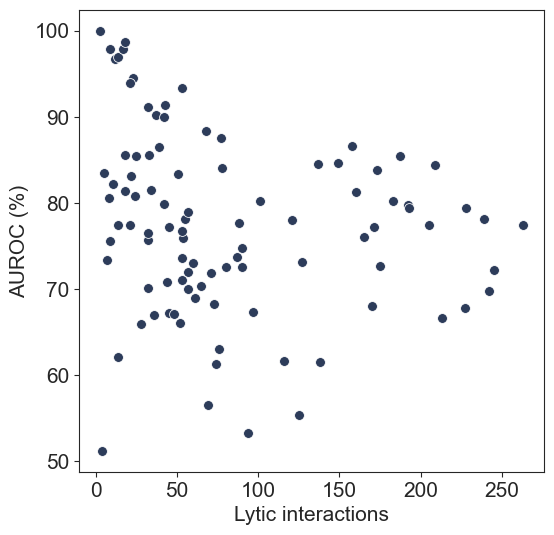

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=perf, x="n_infections", y="auc", ax=ax, color="#2D3C5A", s=50)
ax.set_xlabel("Lytic interactions")
ax.set_ylabel("AUROC (%)")

do_save = True
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/auc_vs_prevalence.svg")

0.85689769900018


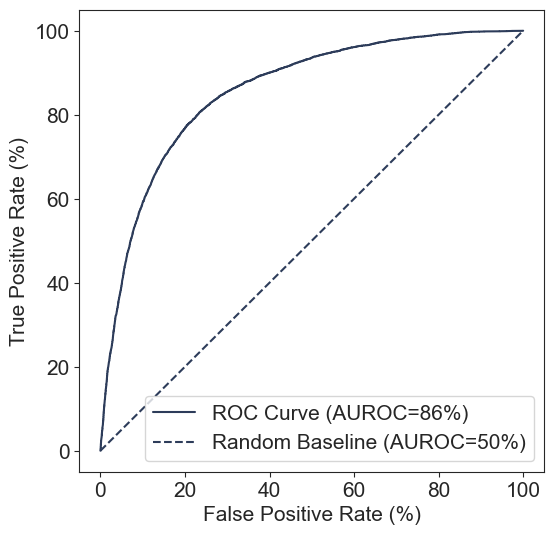

In [128]:
fpr, tpr, thresh = roc_curve(predictions["y"], predictions["y_pred_proba"])
auc_score = roc_auc_score(predictions["y"], predictions["y_pred_proba"])
print(auc_score)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(fpr*100, tpr*100, c="#2D3C5A", label="ROC Curve (AUROC=86%)")
ax.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), "--", c="#2D3C5A", label="Random Baseline (AUROC=50%)")
ax.legend()
ax.set_xlabel("False Positive Rate (%)")
ax.set_ylabel("True Positive Rate (%)")

do_save = True
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/roc_curve.svg")

Text(0.5, 1.0, 'AUC')

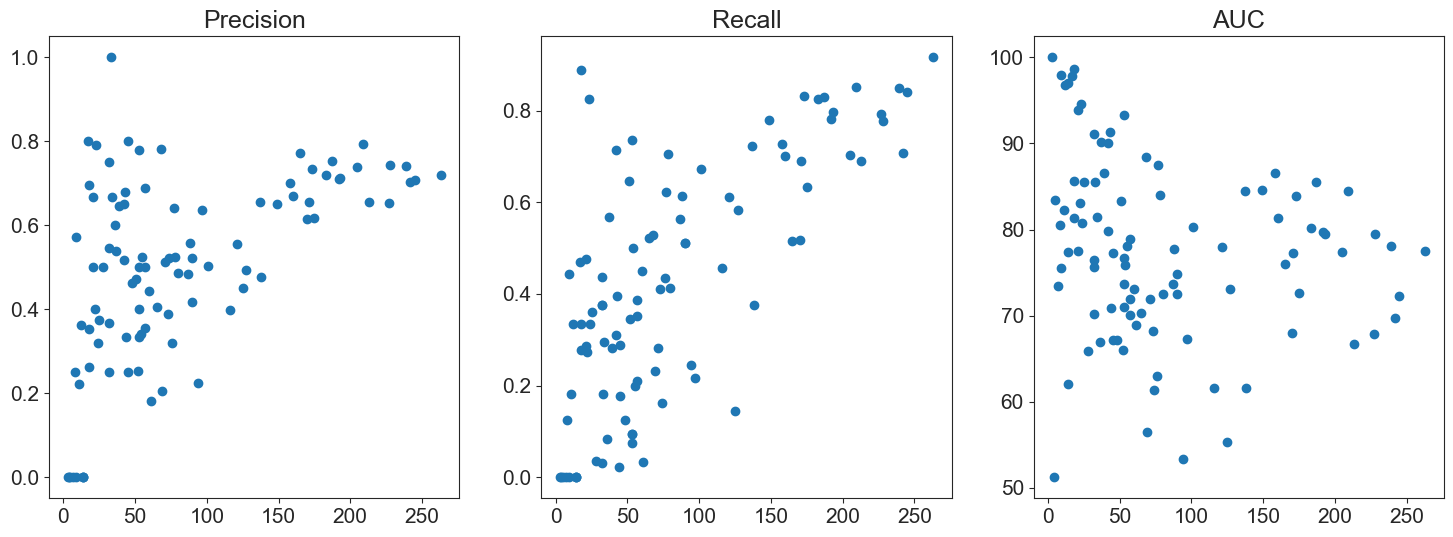

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].scatter(x=perf["n_infections"], y=perf["precision"])
ax[0].set_title("Precision")
ax[1].scatter(x=perf["n_infections"], y=perf["recall"])
ax[1].set_title("Recall")
ax[2].scatter(x=perf["n_infections"], y=perf["auc"])
ax[2].set_title("AUC")